# Computing the optimal statistic with enterprise

In this notebook you will learn how to compute the optimal statistic. The optimal statistic is a frequentist detection statistic for the stochastic background. It assesses the significance of the cross-correlations, and compares them to the Hellings-Downs curve.

For more information, see [Anholm et al. 2009](https://arxiv.org/abs/0809.0701), [Demorest et al. 2013](https://arxiv.org/abs/1201.6641), [Chamberlin et al. 2015](https://arxiv.org/abs/1410.8256), [Vigeland et al. 2018](https://arxiv.org/abs/1805.12188).

This notebook shows you how to compute the optimal statistic for the 12.5yr data set.

To run this notebook without using your own computer, we have prepared a [Google Colab notebook](https://colab.research.google.com/drive/1VNLbutN7cKJM2jl6LId0IgkGJDszDloC#scrollTo=bwMNlFWuQhnB).

## Imports, data loading, and setup

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pickle
import json
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

from enterprise.signals import signal_base
from enterprise.signals import gp_signals, parameter
from enterprise.pulsar import Pulsar
from enterprise_extensions.chromatic.solar_wind import solar_wind_block
from enterprise_extensions.chromatic import dm_exponential_dip

from enterprise_extensions import model_utils, blocks
from enterprise_extensions.frequentist import optimal_statistic as opt_stat

import h5py

import la_forge.core as co

In [2]:
import pickle
with open('/Users/kalistaw/Desktop/OS_2023_data/NG_3P_comparison/epta/dr2new/psrs_epta_dr2new.pkl','rb') as fin:
    psrs=pickle.load(fin)

In [3]:
for p in psrs: 
    print(p.name)

J0030+0451
J0613-0200
J0751+1807
J0900-3144
J1012+5307
J1022+1001
J1024-0719
J1455-3330
J1600-3053
J1640+2224
J1713+0747
J1730-2304
J1738+0333
J1744-1134
J1751-2857
J1801-1417
J1804-2717
J1843-1113
J1857+0943
J1909-3744
J1910+1256
J1911+1347
J1918-0642
J2124-3358
J2322+2057


In [4]:
len(psrs)

25

In [4]:
for p in psrs:
    p.name=p.name+'_epta'

In [5]:
for p in psrs: 
    print(p.name)

J0030+0451_epta
J0613-0200_epta
J0751+1807_epta
J0900-3144_epta
J1012+5307_epta
J1022+1001_epta
J1024-0719_epta
J1455-3330_epta
J1600-3053_epta
J1640+2224_epta
J1713+0747_epta
J1730-2304_epta
J1738+0333_epta
J1744-1134_epta
J1751-2857_epta
J1801-1417_epta
J1804-2717_epta
J1843-1113_epta
J1857+0943_epta
J1909-3744_epta
J1910+1256_epta
J1911+1347_epta
J1918-0642_epta
J2124-3358_epta
J2322+2057_epta


In [6]:
import glob
noise_paths=[]
paths=glob.glob("/Users/kalistaw/Desktop/OS_2023_data/NG_3P_comparison/epta/epta_dr2full_noisefiles/*.json")
for i in paths:
    noise_paths.append(i)

In [7]:
# Load up the noise dictionary to get values for the white noise parameters
# Change the noisefile to point to where you have saved the noisefile
noisedict= {}

for i in noise_paths:
    with open(i, 'r') as f:
        noisefile = json.load(f)
        noisedict.update(noisefile)

In [8]:
noisedict

{'J1801-1417_JBO.DFB.1520_efac': 0.978882,
 'J1801-1417_JBO.DFB.1520_log10_tnequad': -8.51595,
 'J1801-1417_JBO.ROACH.1520_efac': 0.937855,
 'J1801-1417_JBO.ROACH.1520_log10_tnequad': -8.6537,
 'J1801-1417_NRT.BON.1400_efac': 1.38596,
 'J1801-1417_NRT.BON.1400_log10_tnequad': -8.38433,
 'J1801-1417_NRT.NUPPI.1484_efac': 0.587387,
 'J1801-1417_NRT.NUPPI.1484_log10_tnequad': -5.91357,
 'J1801-1417_dm_gp_gamma': 1.3281,
 'J1801-1417_dm_gp_log10_A': -10.6575,
 'J1804-2717_JBO.DFB.1520_efac': 0.994178,
 'J1804-2717_JBO.DFB.1520_log10_tnequad': -7.63536,
 'J1804-2717_JBO.ROACH.1520_efac': 0.978044,
 'J1804-2717_JBO.ROACH.1520_log10_tnequad': -8.57462,
 'J1804-2717_NRT.BON.1400_efac': 0.969574,
 'J1804-2717_NRT.BON.1400_log10_tnequad': -6.38071,
 'J1804-2717_NRT.NUPPI.1484_efac': 0.796183,
 'J1804-2717_NRT.NUPPI.1484_log10_tnequad': -8.62058,
 'J1804-2717_dm_gp_gamma': 0.65558,
 'J1804-2717_dm_gp_log10_A': -11.1584,
 'J0030+0451': 10,
 'J0613-0200': 10,
 'J0751+1807': None,
 'J0900-3144': 138

In [9]:
noisedictcp2=noisedict.copy()
for ky,val in noisedict.items():
    split=ky.split('_')
    split.insert(1,'epta')
    kynew='_'.join(split)
    noisedictcp2[kynew] = noisedict[ky]
for ky,val in noisedict.items():
    if ky in noisedict:
        noisedictcp2.pop(ky)

In [10]:
noisedictcp2

{'J1801-1417_epta_JBO.DFB.1520_efac': 0.978882,
 'J1801-1417_epta_JBO.DFB.1520_log10_tnequad': -8.51595,
 'J1801-1417_epta_JBO.ROACH.1520_efac': 0.937855,
 'J1801-1417_epta_JBO.ROACH.1520_log10_tnequad': -8.6537,
 'J1801-1417_epta_NRT.BON.1400_efac': 1.38596,
 'J1801-1417_epta_NRT.BON.1400_log10_tnequad': -8.38433,
 'J1801-1417_epta_NRT.NUPPI.1484_efac': 0.587387,
 'J1801-1417_epta_NRT.NUPPI.1484_log10_tnequad': -5.91357,
 'J1801-1417_epta_dm_gp_gamma': 1.3281,
 'J1801-1417_epta_dm_gp_log10_A': -10.6575,
 'J1804-2717_epta_JBO.DFB.1520_efac': 0.994178,
 'J1804-2717_epta_JBO.DFB.1520_log10_tnequad': -7.63536,
 'J1804-2717_epta_JBO.ROACH.1520_efac': 0.978044,
 'J1804-2717_epta_JBO.ROACH.1520_log10_tnequad': -8.57462,
 'J1804-2717_epta_NRT.BON.1400_efac': 0.969574,
 'J1804-2717_epta_NRT.BON.1400_log10_tnequad': -6.38071,
 'J1804-2717_epta_NRT.NUPPI.1484_efac': 0.796183,
 'J1804-2717_epta_NRT.NUPPI.1484_log10_tnequad': -8.62058,
 'J1804-2717_epta_dm_gp_gamma': 0.65558,
 'J1804-2717_epta_dm_

In [11]:
"""
#Run once to save renamed files then can load at convience 
noise=noisedictcp2
# create a binary pickle file 
f = open("/Users/kalistaw/Desktop/OS_2023_data/epta_noise_params.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(noise,f)
# close file
f.close()

"""

'\n#Run once to save renamed files then can load at convience \nnoise=noisedictcp2\n# create a binary pickle file \nf = open("/Users/kalistaw/Desktop/OS_2023_data/epta_noise_params.pkl","wb")\n# write the python object (dict) to pickle file\npickle.dump(noise,f)\n# close file\nf.close()\n\n'

In [12]:
### %%time
# (Note: It may take a few minutes to run this cell and may require at least ~4GB RAM)
# Initialize the optimal statistic object
# You can give it a list of pulsars and the noise dictionary, and it will create the pta object for you
# Alternatively, you can make the pta object yourself and give it to the OptimalStatistic object as an argument

# find the maximum time span to set GW frequency sampling
Tspan = 596533603.0710592 #PPTA Tspan

#596533603.0710592 #PPTA Tspan

#596533603.0710592 #PPTA Tspan
#505861299.1401644 #NANOGRAV TSPAN

#596533603.0710592 #PPTA Tspan

#model_utils.get_tspan(psrs)

#505861299.1401644 #NANOGRAV TSPAN



tm = gp_signals.TimingModel(use_svd=True)

wn = blocks.white_noise_block(vary=False, inc_ecorr=False, select='backend',tnequad=True)


rn = blocks.red_noise_block(components=30, Tspan=Tspan)

dmgp = blocks.dm_noise_block(components=100, Tspan=Tspan)

crn = blocks.common_red_noise_block(
    components=10,
    orf= None,
    Tspan=Tspan,
    gamma_val=13/3,
    name="gw"
)

s_crn = tm + wn + rn + dmgp + crn

models = []
for p in psrs:
    s = s_crn
    if p.name == "J1713+0747_epta":
        s += dm_exponential_dip(54700, 54800, 
                                idx=parameter.Uniform(1, 5),
                                name="dmexp_1")
        s += dm_exponential_dip(57500, 57520, 
                                idx=parameter.Uniform(1, 5),
                                name="dmexp_2")

    models.append(s(p))
pta = signal_base.PTA(models)
pta.set_default_params(noisedictcp2)

In [37]:
import cloudpickle
with open('/Users/kalistaw/Desktop/OS_2023_data/epta_models_tspan_ppta_fx_gamma_one_curn_hd.pkl','wb') as fout:
    cloudpickle.dump(pta,fout)

In [15]:
#frequncies_epta=np.array([1/Tspan,2/Tspan,3/Tspan,4/Tspan,5/Tspan,6/Tspan,7/Tspan,8/Tspan,9/Tspan])

In [16]:
#np.save("/Users/kalistaw/Desktop/OS_2023_data/frequncies_epta.npy",frequncies_epta)

In [14]:
pta.param_names

['J0030+0451_epta_dm_gp_gamma',
 'J0030+0451_epta_dm_gp_log10_A',
 'J0030+0451_epta_red_noise_gamma',
 'J0030+0451_epta_red_noise_log10_A',
 'J0613-0200_epta_dm_gp_gamma',
 'J0613-0200_epta_dm_gp_log10_A',
 'J0613-0200_epta_red_noise_gamma',
 'J0613-0200_epta_red_noise_log10_A',
 'J0751+1807_epta_dm_gp_gamma',
 'J0751+1807_epta_dm_gp_log10_A',
 'J0751+1807_epta_red_noise_gamma',
 'J0751+1807_epta_red_noise_log10_A',
 'J0900-3144_epta_dm_gp_gamma',
 'J0900-3144_epta_dm_gp_log10_A',
 'J0900-3144_epta_red_noise_gamma',
 'J0900-3144_epta_red_noise_log10_A',
 'J1012+5307_epta_dm_gp_gamma',
 'J1012+5307_epta_dm_gp_log10_A',
 'J1012+5307_epta_red_noise_gamma',
 'J1012+5307_epta_red_noise_log10_A',
 'J1022+1001_epta_dm_gp_gamma',
 'J1022+1001_epta_dm_gp_log10_A',
 'J1022+1001_epta_red_noise_gamma',
 'J1022+1001_epta_red_noise_log10_A',
 'J1024-0719_epta_dm_gp_gamma',
 'J1024-0719_epta_dm_gp_log10_A',
 'J1024-0719_epta_red_noise_gamma',
 'J1024-0719_epta_red_noise_log10_A',
 'J1455-3330_epta_dm

In [18]:

#Code to generate and save max likelihood parameters only need to run once
#To get the files generated 
#c0 = co.Core(chaindir='/Users/kalistaw/Desktop/OS_2023_data/NG_3P_comparison/epta/dr2new/model_2a_9f/')
#max_like=c0.get_map_dict()
# create a binary pickle file 
#f = open("/Users/physics/Desktop/OS_2023_data/ng_ml_params.json","w")
# write the python object (dict) to pickle file
#json.dump(max_like,f)
# close file
#f.close()


In [19]:
#c0.save("/Users/kalistaw/Desktop/OS_2023_data/epta_dmgp_core_fx_gamma.h5")

In [20]:
c0=co.Core(corepath="/Users/kalistaw/Desktop/OS_2023_data/epta_dmgp_core.h5")

Loading data from HDF5 file....


In [21]:
max_like=c0.get_map_dict()

In [22]:
ml_params=max_like

In [23]:
ml_paramscp=ml_params.copy()
for ky,val in ml_params.items():
    if "earth" not in ky:
        split=ky.split('_')
        split.insert(1,'epta')
        kynew='_'.join(split)
        ml_paramscp[kynew] = ml_params[ky]
    else:
        ml_paramscp[ky] = ml_params[ky]
for ky,val in ml_params.items():
    if ky in ml_params and "earth" not in ky:
        ml_paramscp.pop(ky)
ml_paramscp['gw_log10_A']=ml_paramscp['gw_epta_crn_log10_A']
ml_paramscp['gw_gamma']=ml_paramscp['gw_epta_crn_gamma']

In [24]:
ml_paramscp

{'J0030+0451_epta_dm_gp_gamma': 6.287733903287084,
 'J0030+0451_epta_dm_gp_log10_A': -16.866702968927317,
 'J0030+0451_epta_red_noise_gamma': 0.3006569605959275,
 'J0030+0451_epta_red_noise_log10_A': -15.678464273320698,
 'J0613-0200_epta_dm_gp_gamma': 0.18227638648495326,
 'J0613-0200_epta_dm_gp_log10_A': -14.394981557715115,
 'J0613-0200_epta_red_noise_gamma': 0.9426798027964427,
 'J0613-0200_epta_red_noise_log10_A': -16.05741481151899,
 'J0751+1807_epta_dm_gp_gamma': 2.9596499797942157,
 'J0751+1807_epta_dm_gp_log10_A': -13.521438880089143,
 'J0751+1807_epta_red_noise_gamma': 1.745585472839327,
 'J0751+1807_epta_red_noise_log10_A': -18.749192293691806,
 'J0900-3144_epta_dm_gp_gamma': 1.3737042966495658,
 'J0900-3144_epta_dm_gp_log10_A': -12.66028112788229,
 'J0900-3144_epta_red_noise_gamma': 1.9640705158600926,
 'J0900-3144_epta_red_noise_log10_A': -12.797526753051294,
 'J1012+5307_epta_dm_gp_gamma': 0.7099769376648452,
 'J1012+5307_epta_dm_gp_log10_A': -13.447076473045819,
 'J1012+

In [25]:
dm_gp_max_like=ml_paramscp.copy()
for key,val in ml_paramscp.items():
    if "dm" not in key:
        dm_gp_max_like.pop(key)
    else:
        pass

In [26]:
dm_gp_max_like

{'J0030+0451_epta_dm_gp_gamma': 6.287733903287084,
 'J0030+0451_epta_dm_gp_log10_A': -16.866702968927317,
 'J0613-0200_epta_dm_gp_gamma': 0.18227638648495326,
 'J0613-0200_epta_dm_gp_log10_A': -14.394981557715115,
 'J0751+1807_epta_dm_gp_gamma': 2.9596499797942157,
 'J0751+1807_epta_dm_gp_log10_A': -13.521438880089143,
 'J0900-3144_epta_dm_gp_gamma': 1.3737042966495658,
 'J0900-3144_epta_dm_gp_log10_A': -12.66028112788229,
 'J1012+5307_epta_dm_gp_gamma': 0.7099769376648452,
 'J1012+5307_epta_dm_gp_log10_A': -13.447076473045819,
 'J1022+1001_epta_dm_gp_gamma': 0.29339543396926493,
 'J1022+1001_epta_dm_gp_log10_A': -13.093463426815077,
 'J1024-0719_epta_dm_gp_gamma': 2.8191052457755097,
 'J1024-0719_epta_dm_gp_log10_A': -13.59448442869081,
 'J1455-3330_epta_dm_gp_gamma': 0.9855794445141296,
 'J1455-3330_epta_dm_gp_log10_A': -13.18784649489588,
 'J1600-3053_epta_dm_gp_gamma': 1.9451059610108776,
 'J1600-3053_epta_dm_gp_log10_A': -13.140332120127137,
 'J1640+2224_epta_dm_gp_gamma': 0.32285

In [27]:
f = open("/Users/kalistaw/Desktop/OS_2023_data/epta_dmgp_max.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(dm_gp_max_like,f)
# close file
f.close()

In [28]:
for ky in ml_paramscp.keys():
    if ky not in pta.param_names:
        print(ky)

gw_epta_crn_gamma
gw_epta_crn_log10_A
lnpost_epta
lnlike_epta
chain_epta_accept
pt_epta_chain_accept


In [28]:
for ky in pta.param_names:
    if ky not in ml_paramscp.keys() :
        print(ky)

In [29]:
'''
#Run once to save renamed files then can load at convience 
ml=ml_paramscp
# create a binary pickle file 
f = open("/Users/physics/nanogw/data/ng_ml_params_renamed.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(ml,f)
# close file
f.close()
'''

'\n#Run once to save renamed files then can load at convience \nml=ml_paramscp\n# create a binary pickle file \nf = open("/Users/physics/nanogw/data/ng_ml_params_renamed.pkl","wb")\n# write the python object (dict) to pickle file\npickle.dump(ml,f)\n# close file\nf.close()\n'

## Optimal statistics with maximum likelihood noise parameters

In [30]:
ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd',gamma_common=None)
ostat_dip = opt_stat.OptimalStatistic(psrs, pta=pta, orf='dipole',gamma_common=None)
ostat_mono = opt_stat.OptimalStatistic(psrs, pta=pta, orf='monopole',gamma_common=None)

In [31]:
ostat

In [32]:
ml_paramscp

{'J0030+0451_epta_dm_gp_gamma': 6.287733903287084,
 'J0030+0451_epta_dm_gp_log10_A': -16.866702968927317,
 'J0030+0451_epta_red_noise_gamma': 0.3006569605959275,
 'J0030+0451_epta_red_noise_log10_A': -15.678464273320698,
 'J0613-0200_epta_dm_gp_gamma': 0.18227638648495326,
 'J0613-0200_epta_dm_gp_log10_A': -14.394981557715115,
 'J0613-0200_epta_red_noise_gamma': 0.9426798027964427,
 'J0613-0200_epta_red_noise_log10_A': -16.05741481151899,
 'J0751+1807_epta_dm_gp_gamma': 2.9596499797942157,
 'J0751+1807_epta_dm_gp_log10_A': -13.521438880089143,
 'J0751+1807_epta_red_noise_gamma': 1.745585472839327,
 'J0751+1807_epta_red_noise_log10_A': -18.749192293691806,
 'J0900-3144_epta_dm_gp_gamma': 1.3737042966495658,
 'J0900-3144_epta_dm_gp_log10_A': -12.66028112788229,
 'J0900-3144_epta_red_noise_gamma': 1.9640705158600926,
 'J0900-3144_epta_red_noise_log10_A': -12.797526753051294,
 'J1012+5307_epta_dm_gp_gamma': 0.7099769376648452,
 'J1012+5307_epta_dm_gp_log10_A': -13.447076473045819,
 'J1012+

In [33]:
# Compute the optimal statistic
# The optimal statistic returns five quantities:
#  - xi: an array of the angular separations between the pulsar pairs (in radians)
#  - rho: an array of the cross-correlations between the pulsar pairs
#  - sig: an array of the uncertainty in the cross-correlations
#  - OS: the value of the optimal statistic
#  - OS_sig: the uncertainty in the optimal statistic

xi, rho, sig, OS, OS_sig = ostat.compute_os(params=ml_paramscp) #HD


_, _, _, OS_dip, OS_sig_dip = ostat_dip.compute_os(params=ml_paramscp) #Dipole


_, _, _, OS_mono, OS_sig_mono = ostat_mono.compute_os(params=ml_paramscp) #Monopole 

In [34]:
print(OS, OS_sig, OS/OS_sig)
print(OS_dip, OS_sig_dip, OS_dip/OS_sig_dip)
print(OS_mono, OS_sig_mono, OS_mono/OS_sig_mono)

8.122810105834315e-29 5.608005616638779e-29 1.448431164500654
7.827858862406925e-30 1.3914900144922533e-29 0.5625522843053434
1.3279983516000446e-30 9.51032888024074e-30 0.1396374792420878


## Noise marginalized optimal statistics
* To compute the noise-marginalized optimal statistic (Vigeland et al. 2018), you will need the chain from a Bayesian search for a common red process without spatial correlations (model 2A).

In [13]:
with open ('/Users/kalistaw/Desktop/OS_2023_data/epta_dmgp_max.pkl', 'rb') as fp:
    dm_gp_max_like = pickle.load(fp)

In [14]:
with open ('/Users/kalistaw/Desktop/OS_2023_data/combined_epta_params_fx_gamma.npy', 'rb') as fp:
    epta_param_names = pickle.load(fp)

In [15]:
epta_param_names

['J0030+0451_dm_gp_gamma',
 'J0030+0451_dm_gp_log10_A',
 'J0030+0451_red_noise_gamma',
 'J0030+0451_red_noise_log10_A',
 'J0613-0200_dm_gp_gamma',
 'J0613-0200_dm_gp_log10_A',
 'J0613-0200_red_noise_gamma',
 'J0613-0200_red_noise_log10_A',
 'J0751+1807_dm_gp_gamma',
 'J0751+1807_dm_gp_log10_A',
 'J0751+1807_red_noise_gamma',
 'J0751+1807_red_noise_log10_A',
 'J0900-3144_dm_gp_gamma',
 'J0900-3144_dm_gp_log10_A',
 'J0900-3144_red_noise_gamma',
 'J0900-3144_red_noise_log10_A',
 'J1012+5307_dm_gp_gamma',
 'J1012+5307_dm_gp_log10_A',
 'J1012+5307_red_noise_gamma',
 'J1012+5307_red_noise_log10_A',
 'J1022+1001_dm_gp_gamma',
 'J1022+1001_dm_gp_log10_A',
 'J1022+1001_red_noise_gamma',
 'J1022+1001_red_noise_log10_A',
 'J1024-0719_dm_gp_gamma',
 'J1024-0719_dm_gp_log10_A',
 'J1024-0719_red_noise_gamma',
 'J1024-0719_red_noise_log10_A',
 'J1455-3330_dm_gp_gamma',
 'J1455-3330_dm_gp_log10_A',
 'J1455-3330_red_noise_gamma',
 'J1455-3330_red_noise_log10_A',
 'J1600-3053_dm_gp_gamma',
 'J1600-3053_

In [16]:
epta_param_namescp=[]
for ky in epta_param_names:
    if "earth" not in ky:
        split=ky.split('_')
        split.insert(1,'epta')
        kynew='_'.join(split)
        epta_param_namescp.append(kynew)
    else:
        epta_param_namescp.append(ky)

In [17]:
for i in range(len(epta_param_namescp)):
    if epta_param_namescp[i]=='gw_epta_crn_gamma':
        epta_param_namescp[i]='gw_gamma'
    elif epta_param_namescp[i]=='gw_epta_crn_log10_A':
        epta_param_namescp[i]='gw_log10_A'
    else:
        pass

In [18]:
epta_param_namescp

['J0030+0451_epta_dm_gp_gamma',
 'J0030+0451_epta_dm_gp_log10_A',
 'J0030+0451_epta_red_noise_gamma',
 'J0030+0451_epta_red_noise_log10_A',
 'J0613-0200_epta_dm_gp_gamma',
 'J0613-0200_epta_dm_gp_log10_A',
 'J0613-0200_epta_red_noise_gamma',
 'J0613-0200_epta_red_noise_log10_A',
 'J0751+1807_epta_dm_gp_gamma',
 'J0751+1807_epta_dm_gp_log10_A',
 'J0751+1807_epta_red_noise_gamma',
 'J0751+1807_epta_red_noise_log10_A',
 'J0900-3144_epta_dm_gp_gamma',
 'J0900-3144_epta_dm_gp_log10_A',
 'J0900-3144_epta_red_noise_gamma',
 'J0900-3144_epta_red_noise_log10_A',
 'J1012+5307_epta_dm_gp_gamma',
 'J1012+5307_epta_dm_gp_log10_A',
 'J1012+5307_epta_red_noise_gamma',
 'J1012+5307_epta_red_noise_log10_A',
 'J1022+1001_epta_dm_gp_gamma',
 'J1022+1001_epta_dm_gp_log10_A',
 'J1022+1001_epta_red_noise_gamma',
 'J1022+1001_epta_red_noise_log10_A',
 'J1024-0719_epta_dm_gp_gamma',
 'J1024-0719_epta_dm_gp_log10_A',
 'J1024-0719_epta_red_noise_gamma',
 'J1024-0719_epta_red_noise_log10_A',
 'J1455-3330_epta_dm

In [19]:
epta_array=np.load("/Users/kalistaw/Desktop/OS_2023_data/combined_epta_chain_fx_gamma.npy")

In [20]:
len(epta_array),len(epta_array[422])

(1000, 113)

In [21]:
i=0
while i<len(epta_array):
    dictionary_of_values = dict(zip(epta_param_namescp, epta_array[i]))
    dictionary_of_valcp=dictionary_of_values.copy()
    for key, value in dm_gp_max_like.items():
        for ky,val in dictionary_of_values.items():
            if ky == key:
                dictionary_of_valcp[ky]=value
            else:
                pass
    list_epta_array=[]
    for ky,val in dictionary_of_valcp.items():
        list_epta_array.append(val)
    epta_array[i]=list_epta_array
    
    i+=1

In [22]:
epta_array.shape

(1000, 113)

In [23]:
for ky in epta_param_namescp:
    if ky not in pta.param_names:
        print(ky)

lnpost_epta
lnlike_epta
chain_epta_accept
pt_epta_chain_accept


In [24]:
for ky in pta.param_names:
    if ky not in epta_param_namescp:
        print(ky)

In [25]:
epta_array.shape

(1000, 113)

In [26]:
len(epta_param_namescp)

113

In [26]:
f = open("/Users/kalistaw/Desktop/OS_2023_data/epta_param_names_comined_fx_gamma_unq_indx.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(epta_param_namescp,f)
# close file
f.close()

In [27]:
epta_param_namescp

['J0030+0451_epta_dm_gp_gamma',
 'J0030+0451_epta_dm_gp_log10_A',
 'J0030+0451_epta_red_noise_gamma',
 'J0030+0451_epta_red_noise_log10_A',
 'J0613-0200_epta_dm_gp_gamma',
 'J0613-0200_epta_dm_gp_log10_A',
 'J0613-0200_epta_red_noise_gamma',
 'J0613-0200_epta_red_noise_log10_A',
 'J0751+1807_epta_dm_gp_gamma',
 'J0751+1807_epta_dm_gp_log10_A',
 'J0751+1807_epta_red_noise_gamma',
 'J0751+1807_epta_red_noise_log10_A',
 'J0900-3144_epta_dm_gp_gamma',
 'J0900-3144_epta_dm_gp_log10_A',
 'J0900-3144_epta_red_noise_gamma',
 'J0900-3144_epta_red_noise_log10_A',
 'J1012+5307_epta_dm_gp_gamma',
 'J1012+5307_epta_dm_gp_log10_A',
 'J1012+5307_epta_red_noise_gamma',
 'J1012+5307_epta_red_noise_log10_A',
 'J1022+1001_epta_dm_gp_gamma',
 'J1022+1001_epta_dm_gp_log10_A',
 'J1022+1001_epta_red_noise_gamma',
 'J1022+1001_epta_red_noise_log10_A',
 'J1024-0719_epta_dm_gp_gamma',
 'J1024-0719_epta_dm_gp_log10_A',
 'J1024-0719_epta_red_noise_gamma',
 'J1024-0719_epta_red_noise_log10_A',
 'J1455-3330_epta_dm

In [28]:
dict_list=[]
for ii in range(epta_array.shape[0]):
    param =(dict(zip(epta_param_namescp,epta_array[ii,:])))
    dict_list.append(param)

In [29]:
import json
with open('/Users/kalistaw/Desktop/OS_2023_data/epta_chain_fx_gamma_bf.pkl', 'w') as fout:
    json.dump(dict_list, fout)

In [29]:
np.save('/Users/kalistaw/Desktop/OS_2023_data/combined_epta_chain_fx_gamma_dmgp_set.npy',epta_array)

In [29]:
ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')
ostat_dip = opt_stat.OptimalStatistic(psrs, pta=pta, orf='dipole')
ostat_mono = opt_stat.OptimalStatistic(psrs, pta=pta, orf='monopole')

In [30]:
ahat= []
snr = []
Xi=[]
for ii in range(epta_array.shape[0]):
    param =(dict(zip(epta_param_namescp,epta_array[ii,:])))
    xi, rho, sig, Ahat, Ahat_err = ostat.compute_os(params=param) #HD
    print(Ahat)
    ahat.append(Ahat)
    snr.append(Ahat/Ahat_err)
    Xi.append(xi)

7.170624600902514e-30
6.638844063116535e-30
4.988786479538522e-30
6.998304104680783e-30
8.228172072957326e-30
5.671118677986688e-30
6.632235080858798e-30
6.143271371479379e-30
5.469335394734929e-30
5.938807372636375e-30
7.470109002371599e-30
7.449102337634412e-30
6.891823357601348e-30
1.0019262101040315e-29
6.1680248732586985e-30
5.76604865489377e-30
6.862084447011078e-30
6.304937289541805e-30
1.128571904821387e-29
6.403543378522764e-30
8.708057664706018e-30
9.391151674988688e-30
6.2633246464001436e-30
5.882545200954163e-30
8.239789862716594e-30
8.554001159479102e-30
6.0346890797646045e-30
9.831340183354951e-30
7.056653805267575e-30
8.53478224867387e-30
5.4921989380828776e-30
7.54333444700218e-30
8.037865886305113e-30
8.12847175093313e-30
6.472060018706118e-30
6.474169212421998e-30
9.209989465445329e-30
7.587183976050453e-30
5.91069300888424e-30
6.767878104695124e-30
8.585686516660574e-30
7.343157140601843e-30
5.892889646623665e-30
8.884292304356084e-30
6.666338513476283e-30
5.64702253

6.373821121716513e-30
4.501946819932858e-30
9.618924434897971e-30
6.809158118980144e-30
1.0734790416507463e-29
7.046577790683279e-30
4.6785712002468065e-30
6.480092257516872e-30
7.499479245562813e-30
1.1657349646718458e-29
9.549035038380816e-30
8.458172329070521e-30
7.359667534614302e-30
1.154985061506731e-29
5.183436577734034e-30
4.7753584420976366e-30
5.774926061633469e-30
6.857848296936117e-30
6.496691224585357e-30
6.1663373109304256e-30
6.888906008761018e-30
6.699375438763592e-30
8.582494295152767e-30
1.2378704140998888e-29
6.93945399412031e-30
6.462574813785548e-30
6.19067777299114e-30
1.2462873757054123e-29
7.757569954576422e-30
8.258521734831736e-30
9.262413379452768e-30
6.707946986871982e-30
8.122674696313185e-30
7.170624600902514e-30
6.956792814240648e-30
6.266433437072907e-30
6.699058178787021e-30
7.637983735074483e-30
5.628030034917465e-30
5.628030034917465e-30
5.0650719118003054e-30
6.929332821986562e-30
8.16110232543426e-30
9.251789765686777e-30
1.0942712733720791e-29
5.43

6.514479879544638e-30
5.078490269829012e-30
7.262567082284053e-30
7.999025406243892e-30
5.975939331777596e-30
8.375258060149328e-30
7.4697276920864e-30
7.468051923778562e-30
8.245059769549869e-30
7.051950238122753e-30
5.714931014024727e-30
6.1475200549261624e-30
5.9188667951656246e-30
8.474223893967545e-30
4.892406929701116e-30
8.03028284832773e-30
5.851478468601646e-30
6.2715066391226716e-30
6.804879779403717e-30
6.081613567089893e-30
1.1717783765863382e-29
7.262872381108108e-30
7.711796576735256e-30
7.164017156757341e-30
8.230943304095528e-30
8.615241817884046e-30
4.929286494282545e-30
7.084904552104287e-30
6.635364092384823e-30
4.579423098341949e-30
7.136526485138112e-30
6.5932361518291e-30
6.582468258004582e-30
6.564719467619198e-30
8.054980179885158e-30
6.71954075123265e-30
7.399289942545519e-30
6.863197452109826e-30
8.822669560363523e-30
6.670370625205466e-30
8.410036534873235e-30
6.725727156787007e-30
6.171338873771522e-30
6.030444424929294e-30
4.428110338304487e-30
6.3136247894

In [35]:
import math

In [51]:
Xi

[array([1.5011154 , 1.87570849, 2.16667117, 2.00999221, 2.52954536,
        2.59416697, 2.36887506, 2.1685647 , 1.97545446, 1.88859936,
        1.84506003, 1.78911564, 1.78388662, 1.76027001, 1.71239496,
        1.71075037, 1.53089189, 1.44004663, 1.48799208, 1.38332745,
        1.37523538, 1.37219908, 1.02146858, 0.40254124, 0.54653833,
        0.85984217, 1.29276113, 1.10267956, 1.09429114, 2.11991952,
        2.34535357, 2.60918873, 2.8624054 , 2.66647609, 2.9874263 ,
        2.87253845, 2.59305513, 2.85240022, 2.62860349, 2.87648584,
        2.90855518, 2.41179895, 2.83211904, 2.81714208, 2.81989354,
        2.13836421, 1.7925826 , 0.91779734, 0.77548047, 0.65653342,
        0.79631354, 1.97397184, 2.21064007, 2.06298315, 2.32693392,
        2.56150892, 2.45855728, 2.59611149, 2.6290092 , 2.67921995,
        2.68413516, 2.83264755, 2.60358839, 2.76464386, 2.57137231,
        2.55946489, 2.89943046, 2.6841503 , 2.01008295, 1.50600849,
        0.80590964, 0.54595446, 1.2600911 , 1.48

In [92]:
hd=0
HD=[]
for i in Xi[1]:
    hd = 1/2 + 3/2 * (((1 - np.cos(i))/2)*(np.log(((1 - np.cos(i))/2))- 1/6))
    HD.append(hd)

In [93]:
HD2=[]
for i in HD:
    hd2=(i)**2
    HD2.append(hd2)

In [95]:
len(HD2)

300

In [97]:
sum(HD2)/len(HD2)

0.03526175398700946

In [32]:
snr=np.array(snr)
type(snr)

numpy.ndarray

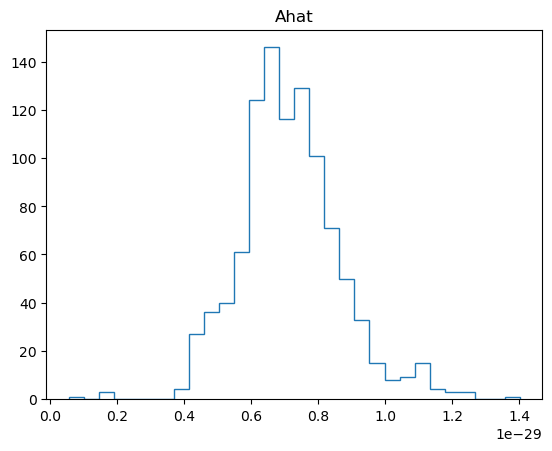

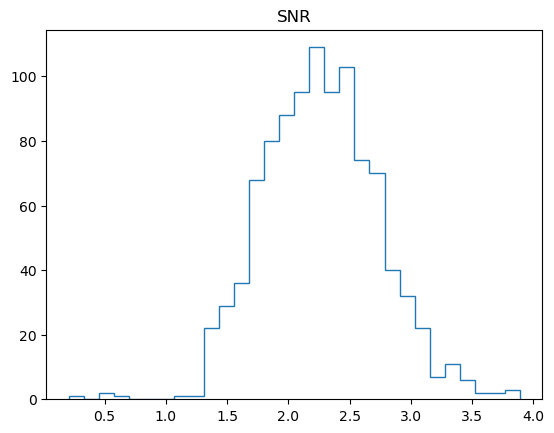

In [33]:
plt.hist(ahat,bins=30,histtype='step')
plt.title("Ahat")
plt.show()

plt.hist(snr,bins=30,histtype='step')
plt.title("SNR")
plt.show()

In [34]:
np.median(snr)

2.2522124394015517

In [35]:
np.save("/Users/kalistaw/Desktop/OS_2023_data/epta_snr_vg_tspan_ppta_fx_gamma_dmgp_set.npy",snr)

In [ ]:
#NMOS in native PTA Space

In [14]:
with open ('/Users/kalistaw/Desktop/OS_2023_data/epta_dmgp_max.pkl', 'rb') as fp:
    dm_gp_max_like = pickle.load(fp)

In [22]:
c0=co.Core(corepath="/Users/kalistaw/Desktop/OS_2023_data/epta_dmgp_core_fx_gamma.h5")

Loading data from HDF5 file....


In [23]:
c0.chain.shape

(368000, 113)

In [24]:
len(c0.params)

113

In [25]:
epta_array=c0.chain
epta_param_names=c0.params

In [26]:
epta_param_namescp=[]
for ky in epta_param_names:
    if "earth" not in ky:
        split=ky.split('_')
        split.insert(1,'epta')
        kynew='_'.join(split)
        epta_param_namescp.append(kynew)
    else:
        epta_param_namescp.append(ky)

In [27]:
for i in range(len(epta_param_namescp)):
    if epta_param_namescp[i]=='gw_epta_crn_gamma':
        epta_param_namescp[i]='gw_gamma'
    elif epta_param_namescp[i]=='gw_epta_crn_log10_A':
        epta_param_namescp[i]='gw_log10_A'
    else:
        pass

In [28]:
i=0
while i<len(epta_array):
    dictionary_of_values = dict(zip(epta_param_namescp, epta_array[i]))
    dictionary_of_valcp=dictionary_of_values.copy()
    for key, value in dm_gp_max_like.items():
        for ky,val in dictionary_of_values.items():
            if ky == key:
                dictionary_of_valcp[ky]=value
            else:
                pass
    list_epta_array=[]
    for ky,val in dictionary_of_valcp.items():
        list_epta_array.append(val)
    epta_array[i]=list_epta_array
    
    i+=1

In [29]:
chain=epta_array

In [30]:
for ky in epta_param_namescp:
    if ky not in pta.param_names:
        print(ky)

lnpost_epta
lnlike_epta
chain_epta_accept
pt_epta_chain_accept


In [31]:
for ky in pta.param_names:
    if ky not in epta_param_namescp:
        print(ky)

In [32]:
ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')
ostat_dip = opt_stat.OptimalStatistic(psrs, pta=pta, orf='dipole')
ostat_mono = opt_stat.OptimalStatistic(psrs, pta=pta, orf='monopole')

In [33]:
%%time
# (Note: It may take a few minutes to run this cell)
N = 1000   # number of times to compute the optimal statistic - official analysis used 10k - you can increase this if you don't mind the extra runtime
burn = int(0.25*chain.shape[0])   # estimate of when the chain has burned in

noisemarg_OS, noisemarg_OS_err = np.zeros(N), np.zeros(N)
noisemarg_OS_dip, noisemarg_OS_dip_err = np.zeros(N), np.zeros(N)
noisemarg_OS_mono, noisemarg_OS_mono_err = np.zeros(N), np.zeros(N)

for i in range(N):
    if i%100==0:
        print("Status: ", i, "/", N, " -- ", i/N*100, " %")
    # choose a set of noise values from the chain
    # make sure that you pull values from after the chain has burned in
    idx = np.random.randint(burn, chain.shape[0])
    
    # construct a dictionary with these parameter values
    param_dict = {}
    for p in epta_param_namescp:
        param_dict.update({p: chain[idx, epta_param_namescp.index(p)]})
    
    # compute the optimal statistic at this set of noise values and save in an array
    _, _, _, noisemarg_OS[i], noisemarg_OS_err[i] = ostat.compute_os(params=param_dict)

Status:  0 / 1000  --  0.0  %
Status:  100 / 1000  --  10.0  %
Status:  200 / 1000  --  20.0  %
Status:  300 / 1000  --  30.0  %
Status:  400 / 1000  --  40.0  %
Status:  500 / 1000  --  50.0  %
Status:  600 / 1000  --  60.0  %
Status:  700 / 1000  --  70.0  %
Status:  800 / 1000  --  80.0  %
Status:  900 / 1000  --  90.0  %
CPU times: user 47.7 s, sys: 1.85 s, total: 49.6 s
Wall time: 34.4 s


In [34]:
snr=noisemarg_OS/noisemarg_OS_err

In [35]:
np.median(snr)

1.7255177600316107

In [36]:
np.save("/Users/kalistaw/Desktop/OS_2023_data/epta_pta_space_mar_snr_fx_gamma_dmgp_set.npy",snr)